In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import numpy as np
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

b


In [2]:
### Load in data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
### Calculate the mean of the usrts
unit_usrt_j = np.concatenate((unit_usrt1[good_indexes], unit_usrt2[good_indexes], unit_usrt3[good_indexes]), axis=0)
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1[good_indexes]])
mean_usrt2 = np.array([[i.mean() for i in j] for j in unit_usrt2[good_indexes]])
mean_usrt3 = np.array([[i.mean() for i in j] for j in unit_usrt3[good_indexes]])
mean_all_usrt = np.concatenate((mean_usrt1, mean_usrt2, mean_usrt3), axis=0)
norm_mean_all_usrt = (mean_all_usrt - np.min(mean_all_usrt, axis=-1)[:, np.newaxis])/(np.max(mean_all_usrt, axis=-1)[:, np.newaxis] - np.min(mean_all_usrt, axis=-1)[: ,np.newaxis])

In [4]:
### Load in the fit models
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Data/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Data/230320_conc_models1.pkl', 'rb')).load()
diff_models_j = np.concatenate((diff_models1, diff_models2, diff_models3), axis=0)



In [5]:
### Extract the bins
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [6]:
### Apply PCA to the bins
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)

In [11]:

def plot_selected_cell_response(usrt_joined, cell_index, ax=None, color='k', tickfontsize=5):
    '''Plots the response of a single cell to all stimuli (part E)'''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    select_cell = usrt_joined[cell_index]
    cell_stds = [np.std(i.mean(axis=-1)) for i in select_cell]
    cell_means = [np.mean(i.mean(axis=-1)) for i in select_cell]
    ax.errorbar(range(32), cell_means, yerr=cell_stds, c=color, fmt='o', markersize=3, linewidth=1)
    ax.set_xticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90, fontsize=tickfontsize)
    ax.set_ylabel('Firing rate (Hz)')
    #ax.set_xlabel('Stimuli')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_selected_cell_heatmap(usrt_joined, cell_index, trial_indexes=range(32), ax=None, cmap='viridis', tickfontsize=5, rotate_xticks=False, cbar_label=None):
    '''Plots the response of a single cell to all stimuli as a heatmap (part E)'''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    select_cell = usrt_joined[cell_index]
    cell_means = [i.mean(axis=0) for i in select_cell]
    im = ax.imshow(cell_means, aspect='auto', cmap=cmap)
    cbar = plt.colorbar(mappable=im, ax=ax)
    cbar.ax.set_ylabel(cbar_label)
    ax.set_yticks(range(32))
    ax.set_yticklabels(glyphs, fontsize=tickfontsize)
    ax.set_xticks([0, 10, 20, 30, 40])
    if rotate_xticks:
        rotation = 90
    else:
        rotation = 0
    ax.set_xticklabels([0, 100, 200, 300, 400], rotation=rotation)
    #ax.set_ylabel('Stimuli')
    ax.set_xlabel('Time (ms)')
    return cbar

def plot_select_cell_response_and_heatmap(fig, gs, unit_usrt_j, unit_id, color_cmap, tickfontsize=4, wspace=0.5, rotation=True, cbar_label=None, heatmap_shift=0.0):
    sub_gs = gs.subgridspec(1, 2, wspace=wspace)
    ax1 = fig.add_subplot(sub_gs[0])
    ax2 = fig.add_subplot(sub_gs[1])
    plot_selected_cell_response(unit_usrt_j, unit_id, ax=ax1, color=color_cmap[0], tickfontsize=tickfontsize)
    cbar = plot_selected_cell_heatmap(unit_usrt_j, unit_id, ax=ax2, cmap=color_cmap[1], tickfontsize=tickfontsize, rotate_xticks=rotation, cbar_label=cbar_label)
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0+heatmap_shift, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0+heatmap_shift, cbar_pos.y0, cbar_pos.width, cbar_pos.height])
    return ax1, ax2

def plot_select_cell_response_and_heatmap(fig, gs, unit_usrt_j, unit_id, color_cmap, tickfontsize=4, wspace=0.5, rotation=True, cbar_label=None, heatmap_shift=0.0, show_model_weights=False):
    sub_gs = gs.subgridspec(1, 2, wspace=wspace)
    axs = []
    if show_model_weights:
        sub_sub_gs = sub_gs[0].subgridspec(4, 1)
        ax1 = fig.add_subplot(sub_sub_gs[1:])
        model_ax = fig.add_subplot(sub_sub_gs[0])
        xs = [0, 1, 2, 3, 4] + [6, 7, 8, 9]
        model_ax.bar(xs, diff_models_j[unit_id].opt_out.x[:-1], color=color_cmap[0])
        model_ax.spines['right'].set_visible(False)
        model_ax.spines['top'].set_visible(False)
        model_ax.spines['left'].set_visible(False)
        model_ax.spines['bottom'].set_visible(False)
        model_ax.set_xticks([])
        model_ax.axhline(0, zorder=-1, color='k', linewidth=0.5)
        model_ax.set_yticks([])
        model_ax.axvline(5, zorder=-1, color='k', linewidth=0.5)
        axs.append(model_ax)
    else:
        ax1 = fig.add_subplot(sub_gs[0])
    axs.append(ax1)
    ax2 = fig.add_subplot(sub_gs[1])
    plot_selected_cell_response(unit_usrt_j, unit_id, ax=ax1, color=color_cmap[0], tickfontsize=tickfontsize)
    cbar = plot_selected_cell_heatmap(unit_usrt_j, unit_id, ax=ax2, cmap=color_cmap[1], tickfontsize=tickfontsize, rotate_xticks=rotation, cbar_label=cbar_label)
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0+heatmap_shift, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0+heatmap_shift, cbar_pos.y0, cbar_pos.width, cbar_pos.height])
    axs.append(ax2)
    return axs

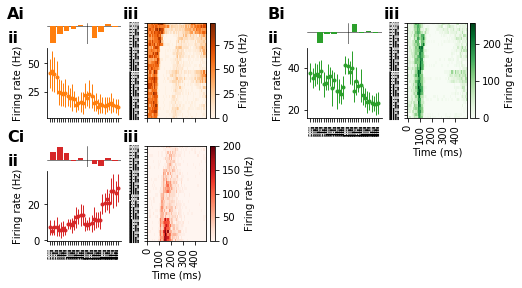

In [24]:
fs = 4
heatmap_shift = -0.02
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 2, wspace=0.4, hspace=0.3)

max1, sax11, sax12 = plot_select_cell_response_and_heatmap(fig, gs[0, 0], unit_usrt_j, 162, ['C1', 'Oranges'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift, show_model_weights=True)
max2, sax21, sax22 = plot_select_cell_response_and_heatmap(fig, gs[0, 1], unit_usrt_j, 233, ['C2', 'Greens'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift, show_model_weights=True)
max3, sax31, sax32 = plot_select_cell_response_and_heatmap(fig, gs[1, 0], unit_usrt_j, 50, ['C3', 'Reds'], tickfontsize=fs, cbar_label='Firing rate (Hz)', heatmap_shift=heatmap_shift, show_model_weights=True)
sax12.set_xticklabels([])
sax11.set_xticklabels([])
sax12.set_xlabel('')
axes = [max1, sax11, sax12, max2, sax21, sax22, max3, sax31, sax32]
labels = ['Ai', 'ii', 'iii', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii']
align_x = [[0, 1, 6, 7], [2, 8], [3, 4]]
align_y = [[0, 2, 3, 5], [6, 8]]
dx = [-0.01]*9
dy = [0.01]*9
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dx=dx, dy=dy)
plt.savefig('230912_Sup62.pdf', bbox_inches='tight')